#### This Notebook is for analyzing uncertainty of SpeCollate embeddings

In [2]:
import ast
import os
import pickle
import re
from collections import OrderedDict
from configparser import ConfigParser
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.special import iv, logsumexp
from spherecluster import VonMisesFisherMixture
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

import run_train as main
from src.snaptrain import dataset, trainmodel

/lclhome/mtari008/anaconda3/envs/deepsnap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/lclhome/mtari008/anaconda3/envs/deepsnap/lib/python3.10/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Temporary config func. Original one in the project.
class config:
    """Define constants"""

    AAMass = OrderedDict(
        [
            ("A", 71.037114),
            ("C", 103.009185),
            ("D", 115.026943),
            ("E", 129.042593),
            ("F", 147.068414),
            ("G", 57.021464),
            ("H", 137.058912),
            ("I", 113.084064),
            ("K", 128.094963),
            ("L", 113.084064),
            ("M", 131.040485),
            ("N", 114.042927),
            ("P", 97.052764),
            ("Q", 128.058578),
            ("R", 156.101111),
            ("S", 87.032028),
            ("T", 101.047679),
            ("V", 99.068414),
            ("W", 186.079313),
            ("Y", 163.0633),
            ("p", 79.9663),
            ("o", 15.994915),
            ("h", 0.9840),
            ("c", 57.02146),
            ("a", 42.0106),
            ("r", -17.026549),
            ("y", 43.00581),
            ("d", -18.010565),
            ("t", 26.02),
        ]
    )

    aas = ["_PAD"] + list(AAMass.keys())
    aa2idx = {a: i for i, a in enumerate(aas)}

    ModMass = {
        "Oxidation": 15.994915,
        "CAM": 57.02146,
        "Carbamidomethyl": 57.02146,
        "ICAT_light": 227.12,
        "ICAT_heavy": 236.12,
        "AB_old_ICATd0": 442.20,
        "AB_old_ICATd8": 450.20,
        "Acetyl": 42.0106,
        "Deamidation": 0.9840,
        "Pyro-cmC": -17.026549,
        "Pyro-glu": -17.026549,
        "Pyro_glu": -18.010565,
        "Amide": -0.984016,
        "Phospho": 79.9663,
        "Methyl": 14.0157,
        "Carbamyl": 43.00581,
    }

    ModCHAR = OrderedDict(
        [
            ("15.99", "o"),
            ("57.02", "c"),
            ("0.98", "h"),
            ("42.01", "a"),
            ("-17.03", "r"),
            ("79.97", "p"),
            ("43.01", "y"),
            ("-18.01", "d"),
            ("26.02", "t"),
        ]
    )

    # ModCHAR = {"15.99": "o", "0.98": "h", "57.02": "c", "42.01": "a", "-17.03": "r", "79.97": "p"}
    Ignore = ["U", "X"]
    Mods = [
        {"mod_char": "p", "aas": ["S", "T", "Y"]}
        # {"mod_char": "o", "aas": ["nt", "M"]}
    ]
    H2O = 18.010564683
    NH3 = 17.031
    PROTON = 1.00727647

    DEFAULT_PARAM_PATH = os.path.join(os.getcwd(), "config.ini")
    PARAM_PATH = None
    l_config = None

    def get_config(section="input", key=None):
        """Read the configuration parameters and return a dictionary."""

        # If file path is given use it otherwise use default.
        file_path = config.PARAM_PATH if config.PARAM_PATH else config.DEFAULT_PARAM_PATH

        # Read config and convert each value to appropriate type.
        # Only for the first time.
        if not config.l_config:
            config.l_config = dict()
            config_ = ConfigParser()
            assert isinstance(file_path, str)
            config_.read(file_path)
            for section_ in config_.sections():
                config.l_config[section_] = dict()
                for key_ in config_[section_]:
                    try:
                        config.l_config[section_][key_] = ast.literal_eval(config_[section_][key_])
                    except (ValueError, SyntaxError):
                        config.l_config[section_][key_] = config_[section_][key_]

        if section and section in config.l_config:
            if key and key in config.l_config[section]:
                return config.l_config[section][key]
            return config.l_config[section]
        return config.l_config

In [4]:
print(config.get_config(section="search", key="charge"))
print(config.get_config(section="input", key="use_mods"))
print(config.get_config(section="ml", key="batch_size"))
print(config.get_config(section="input", key="num_species"))
print(config.get_config(section="search", key="num_mods"))
print(config.get_config(section="input", key="spec_size"))

5
False
1024
9
2
80000


In [5]:
def ppm(val, ppm_val):
    return (ppm_val / 1000000) * val

In [6]:
# adding useless comment
class Net(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size=512,
        embedding_dim=512,
        hidden_lstm_dim=1024,
        lstm_layers=2,
    ):
        super(Net, self).__init__()
        self.spec_size = config.get_config(section="input", key="spec_size")
        self.spec_size = 80000
        self.seq_len = config.get_config(section="ml", key="pep_seq_len")
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.hidden_lstm_dim = hidden_lstm_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        ################### Spectra branch ###################
        self.linear1_1 = nn.Linear(self.spec_size, 512)
        self.linear1_2 = nn.Linear(512, 256)

        ################### Peptide branch ###################
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            self.hidden_lstm_dim,
            self.lstm_layers,
            # dropout=0.5,
            batch_first=True,
            bidirectional=True,
        )

        self.linear2_1 = nn.Linear(self.hidden_lstm_dim * 2, 512)  # 2048, 1024
        self.linear2_2 = nn.Linear(512, 256)
        do = config.get_config(section="ml", key="dropout")
        self.dropout1_1 = nn.Dropout(do)
        self.dropout2_1 = nn.Dropout(do)
        self.dropout2_2 = nn.Dropout(do)
        print("dropout: {}".format(do))

    def forward(self, data, data_type=None):
        assert not data_type or data_type == "specs" or data_type == "peps"
        res = []
        if not data_type or data_type == "specs":
            specs = data[0].squeeze()

            out = F.relu((self.linear1_1(specs.view(-1, self.spec_size))))
            out = self.dropout1_1(out)

            out_spec = F.relu(self.linear1_2(out))
            out_spec = F.normalize(out_spec)
            res.append(out_spec)

        if not data_type or data_type == "peps":
            for peps in data[1:3]:
                peps = peps.squeeze()
                embeds = self.embedding(peps)
                hidden = self.init_hidden(len(peps))
                hidden = tuple([e.data for e in hidden])
                lstm_out, _ = self.lstm(embeds, hidden)
                lstm_out = lstm_out[:, -1, :]
                out = lstm_out.contiguous().view(-1, self.hidden_lstm_dim * 2)
                out = self.dropout2_1(out)

                out = F.relu((self.linear2_1(out)))
                out = self.dropout2_2(out)

                out_pep = F.relu(self.linear2_2(out))
                out_pep = F.normalize(out_pep)
                res.append(out_pep)
        return res

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
        )
        return hidden

    def one_hot_tensor(self, peps):
        batch_size = len(peps)
        src = torch.zeros((batch_size, self.seq_len), dtype=torch.float16, device="cuda")
        src[peps > 0] = 1.0
        one_hots = torch.zeros(
            (batch_size, self.seq_len, self.vocab_size),
            dtype=torch.float16,
            device="cuda",
        )
        one_hots.scatter_(
            2,
            peps.view(batch_size, self.seq_len, 1),
            src.view(batch_size, self.seq_len, 1),
        )
        one_hots.requires_grad = True
        return one_hots

    def name(self):
        return "Net"

In [7]:
rank = 0
world_size = 1
main.setup(rank, world_size)

In [8]:
model_name = "512-embed-2-lstm-SnapLoss2D-80k-nist-massive-no-mc-semi-r2r2r-22.pt"
snap_model = Net(vocab_size=30, embedding_dim=512, hidden_lstm_dim=512, lstm_layers=2).to(rank)
snap_model = nn.parallel.DistributedDataParallel(snap_model, device_ids=[rank])
snap_model.load_state_dict(torch.load("./models/{}".format(model_name))["model_state_dict"])
snap_model = snap_model.module
snap_model.eval()
print(snap_model)

dropout: 0.3
Net(
  (linear1_1): Linear(in_features=80000, out_features=512, bias=True)
  (linear1_2): Linear(in_features=512, out_features=256, bias=True)
  (embedding): Embedding(30, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (linear2_1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2_2): Linear(in_features=512, out_features=256, bias=True)
  (dropout1_1): Dropout(p=0.3, inplace=False)
  (dropout2_1): Dropout(p=0.3, inplace=False)
  (dropout2_2): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Training Data Embeddings
batch_size = config.get_config(section="ml", key="batch_size")
# in_tensor_dir = config.get_config(section='preprocess', key='in_tensor_dir') # for raptor
in_tensor_dir = "/lclhome/mtari008/data/deepsnap/nist_massiv_80k_no_ch_graymass-semi"  # for comet

(
    train_peps,
    train_specs,
    train_masses,
    test_peps,
    test_specs,
    test_masses,
) = main.read_split_listings(in_tensor_dir)

np_specs = []
spec_path = join(in_tensor_dir, "spectra")

# Wrap the outer loop with tqdm
for spec_file_list in tqdm(train_specs, desc="Outer Loop"):
    for spec_file in spec_file_list:
        np_spec = np.load(join(spec_path, spec_file))
        np_specs.append(np_spec)


In [8]:
train_dataset = dataset.LabeledSpectra(in_tensor_dir, train_peps, train_specs)
test_dataset = dataset.LabeledSpectra(in_tensor_dir, test_peps, test_specs)

train_peps_strings, train_dpeps_strings = [], []
for train_pep in train_peps_strings:
    pep_path = join(in_tensor_dir, "peptides", train_pep)
    with open(pep_path, "r") as f:
        pep = f.readlines()[0].strip()
        train_peps_strings.append(pep)
        dpep = train_dataset.get_decoy(pep)
        if dpep:
            train_dpeps_strings.append(dpep)

vocab_size = train_dataset.vocab_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=train_batch_sampler
    batch_size=batch_size,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=test_batch_sampler,
    batch_size=batch_size,
    shuffle=False,
)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(rank)

q, p, d, train_spec_labels, train_spec_charges, train_spec_masses = [], [], [], [], [], []
print("Num batches: {}".format(len(train_loader)))
for idx, data in enumerate(train_loader):
    if idx % 1000 == 0:
        print("Batch: {}".format(idx))
    q_len = len(data[0])
    p_len = len(data[1])
    d_len = len(data[2])
    if p_len > d_len:
        seq_len = config.get_config(section="ml", key="pep_seq_len")  # + charge
        zero_pad = torch.zeros(p_len - d_len, seq_len, dtype=torch.long)
        data[2] = torch.cat((data[2], zero_pad))
    data[0] = data[0].to(rank)  # spectra
    data[1] = data[1].to(rank)  # peptides
    data[2] = data[2].to(rank)  # decoys
    Q, P, D = snap_model(data[:-1])
    Q = Q.detach().cpu().numpy()
    P = P.detach().cpu().numpy()
    D = D.detach().cpu().numpy()
    q.append(Q)
    p.append(P)
    d.append(D)
    l_spec_labels = np.repeat(np.arange(data[-1].size), data[-1])
    train_spec_labels.append(l_spec_labels)
    train_spec_charges.append(data[3])
    train_spec_masses.append(data[4])

q = np.concatenate(q)
p = np.concatenate(p)
d = np.concatenate(d)
train_spec_labels = np.concatenate(train_spec_labels)
train_spec_charges = np.concatenate(train_spec_charges)
train_spec_masses = np.concatenate(train_spec_masses)

NameError: name 'in_tensor_dir' is not defined

In [10]:
# Sort q, train_dataset.np_specs, train_spec_charges by train_spec_masses
print("Sorting data by mass...")
zipped = zip(q, np_specs, train_spec_charges, train_spec_masses)
print(len(q), len(np_specs), len(train_spec_charges), len(train_spec_masses))
sorted_zipped = sorted(zipped, key=lambda x: x[-1])
q, np_specs, train_spec_charges, train_spec_masses = zip(*sorted_zipped)

print("Saving training data embeddings...")
np.save("uncertainty_analysis/training_data/q.npy", q)
np.save("uncertainty_analysis/training_data/p.npy", p)
np.save("uncertainty_analysis/training_data/d.npy", d)
np.save("uncertainty_analysis/training_data/spec_labels.npy", train_spec_labels)
np.save("uncertainty_analysis/training_data/charges.npy", train_spec_charges)
np.save("uncertainty_analysis/training_data/masses.npy", train_spec_masses)
pickle.dump(np_specs, open("uncertainty_analysis/training_data/np_specs.pkl", "wb"))
pickle.dump(train_peps_strings, open("uncertainty_analysis/training_data/peps.pkl", "wb"))
pickle.dump(train_dpeps_strings, open("uncertainty_analysis/training_data/dpeps.pkl", "wb"))

Sorting data by mass...
3166015 3166015 3166015 3166015
Saving training data embeddings...


In [9]:
# load q, p, d, spec_labels, charges, peps, dpeps
q = np.load("uncertainty_analysis/training_data/q.npy")
# p = np.load("uncertainty_analysis/training_data/p.npy")
# d = np.load("uncertainty_analysis/training_data/d.npy")
# train_spec_labels = np.load("uncertainty_analysis/training_data/spec_labels.npy")
train_spec_charges = np.load("uncertainty_analysis/training_data/charges.npy")
train_spec_masses = np.load("uncertainty_analysis/training_data/masses.npy").flatten()
train_np_specs = pickle.load(open("uncertainty_analysis/training_data/np_specs.pkl", "rb"))
# train_peps_strings = pickle.load(open("uncertainty_analysis/training_data/peps.pkl", "rb"))
# train_dpeps_strings = pickle.load(open("uncertainty_analysis/training_data/dpeps.pkl", "rb"))

In [10]:
import random

# batch_size  = config.get_config(section="ml", key="batch_size")
in_tensor_dir = "/lclhome/mtari008/data/deepsnap/proteome-tools"
# in_tensor_dir = "/disk/raptor-2/mtari008/data/deepsnap/train-ready/proteome-tools/"

with open(join(in_tensor_dir, "pep_spec.pkl"), "rb") as f:
    dir_listing = pickle.load(f)

# random.shuffle(dir_listing)

dir_listing = sorted(dir_listing, key=lambda x: float(re.search(r"(\d+)-(\d+.\d+).[pep]", x[0])[2]))
pre_mass = 2000
tol = 100
len_spec_list = 15
total_count = 1000000
min_mass = pre_mass - 1  # ppm(pre_mass, tol)
max_mass = pre_mass + 1  # ppm(pre_mass, tol)

l_pep_file_names = []
l_spec_file_names_lists = []
num_specs = []
count = 0
pep_set = set()
for pep, spec_list in dir_listing:
    pep_mass = float(re.search(r"(\d+)-(\d+.\d+).[pep]", pep)[2])
    #     if len(spec_list) >= 3 and min_mass < pep_mass < max_mass:
    if len(spec_list) >= len_spec_list and pep_mass > 500:
        # print(pep_mass)
        #         print(pep)
        #         print(spec_list)
        l_pep_file_names.append(pep)
        l_spec_file_names_lists.append(spec_list)
        num_specs.append(len(spec_list))
        count += 1
        if count >= total_count:
            break

assert len(l_pep_file_names) == len(l_spec_file_names_lists)
print(len(l_pep_file_names))

2079


In [11]:
def drop_columns_by_percentage(array, percentage):
    if percentage < 0 or percentage > 1:
        raise ValueError("Percentage should be between 0 and 1")

    if percentage == 0:
        return array

    num_columns_to_drop = int(array.shape[1] * percentage)
    random_indices = random.sample(range(array.shape[1]), num_columns_to_drop)
    column_mask = np.ones(array.shape[1], dtype=bool)
    column_mask[random_indices] = False
    return array[:, column_mask]


def get_dense_tensor_from_sparse_numpy(sparse_array, means, stds, spec_size, drop_percentage=0.0):
    sparse_array = drop_columns_by_percentage(sparse_array, drop_percentage)
    ind = torch.LongTensor(np.array([[0] * sparse_array.shape[1], sparse_array[0]]))
    val = torch.FloatTensor(sparse_array[1])
    dense_array = torch.sparse_coo_tensor(ind, val, torch.Size([1, spec_size])).to_dense()
    return (dense_array - means) / stds


def pad_left(arr, size):
    out = np.zeros(size)
    out[-len(arr) :] = arr
    return out


def get_pep(pep_file_name, seq_len):
    with open(pep_file_name, "r") as f:
        pep = f.readlines()[0].strip()

    pepl = [config.aa2idx[aa] for aa in pep]
    pepl = pad_left(pepl, seq_len)
    torch_pep = torch.tensor(pepl, dtype=torch.long)

    return torch_pep, pep

In [12]:
seq_len = config.get_config(section="ml", key="pep_seq_len")
pep_path = join(in_tensor_dir, "peptides")
train_peps_strings = []
test_pep_strings = []

spec_path = join(in_tensor_dir, "spectra")
spec_size = config.get_config(section="input", key="spec_size")

means = np.load(join(in_tensor_dir, "means.npy"))
stds = np.load(join(in_tensor_dir, "stds.npy"))
means = torch.from_numpy(means).float()
stds = torch.from_numpy(stds).float()

torch_spec_list, test_np_specs, test_spec_charge_list, test_spec_mass_list = [], [], [], []
allowed_charged = {2, 3, 4}
# allowed_charged = {2}
percentages = [0.0, 0.05, 0.1, 0.15]
# percentages = [0.0]
num_specs = []
for spec_file_list, pep_file_name in zip(l_spec_file_names_lists, l_pep_file_names):
    pep_path = join(in_tensor_dir, "peptides")
    pep_file_name = join(pep_path, pep_file_name)
    torch_pep, pep = get_pep(pep_file_name, seq_len)
    found_charges = set()
    count = 0
    for spec_file in spec_file_list:
        file_parts = re.search(r"(\d+)\.(\d+)-(\d+)-(\d+.\d+)-(\d+)-(\d+).[pt|npy]", spec_file)
        spec_mass = float(file_parts[4])
        spec_charge = int(file_parts[5])
        if spec_charge not in allowed_charged or spec_charge in found_charges:
            continue
        found_charges.add(spec_charge)
        np_spec = np.load(join(spec_path, spec_file))
        for drop_percentage in percentages:
            count += 1
            torch_spec = get_dense_tensor_from_sparse_numpy(
                np_spec, means, stds, spec_size, drop_percentage=drop_percentage
            )
            test_np_specs.append(np_spec)
            torch_spec_list.append(torch_spec)
            test_spec_charge_list.append(spec_charge)
            test_spec_mass_list.append(spec_mass)

    if count == len(percentages) * len(allowed_charged):
        num_specs.append(count)
        train_peps_strings.append(torch_pep)
        test_pep_strings.append(pep)
    else:
        # pop the count values from torch_spec_list, spec_charge_list, spec_mass_list
        for i in range(count):
            torch_spec_list.pop()
            test_np_specs.pop()
            test_spec_charge_list.pop()
            test_spec_mass_list.pop()

    # torch_spec_charge_list = [self.charge2idx[charge] for charge in torch_spec_charge_list]
test_spec_charges = np.array(test_spec_charge_list)
test_spec_masses = np.array(test_spec_mass_list)
print(test_spec_charges.shape)
torch_specs = torch.cat(torch_spec_list, dim=0)
torch_peps = torch.stack(train_peps_strings, dim=0)
print(len(torch_peps))

(20688,)
1724


In [13]:
def spec_collate(batch):
    #     specs = torch.stack([item for item in batch], 0)
    dummy_pep = np.zeros(config.get_config(section="ml", key="pep_seq_len"))
    dummy_pep = torch.from_numpy(dummy_pep).long().unsqueeze(0)
    return [batch, dummy_pep]


def pep_collate(batch):
    #     peps = torch.stack([item for item in batch], 0)
    dummy_spec = np.zeros(config.get_config(section="input", key="spec_size"))
    dummy_spec = torch.from_numpy(dummy_spec).float().unsqueeze(0)
    dummy_pep = np.zeros((2, config.get_config(section="ml", key="pep_seq_len")))
    dummy_pep = torch.from_numpy(dummy_pep).long()  # .unsqueeze(0)
    # tqdm.write("{}".format(peps.shape))
    # tqdm.write("{}".format(dummy_pep.shape))
    return [dummy_spec, batch, dummy_pep]


def runModel(batch, s_model, in_type, device):
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        out_out = torch.Tensor().cpu()
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        if in_type == "specs":
            out_ = s_model(batch, data_type=in_type)[0]
        elif in_type == "peps":
            batch[2] = batch[2].to(device)
            out_ = s_model(batch, data_type=in_type)[0]
        out_out = torch.cat((out_out, out_.to("cpu")), dim=0)
        # bar.update(batch_idx)
    return out_out

In [14]:
torch_specs_collated = spec_collate(torch_specs)
torch_peps_collated = pep_collate(torch_peps)
test_e_specs = runModel(torch_specs_collated, snap_model, "specs", rank).detach().numpy()
test_e_peps = runModel(torch_peps_collated, snap_model, "peps", rank).detach().numpy()
test_spec_charges = np.array(test_spec_charge_list)
num_specs = np.array(num_specs)
test_spec_labels = np.repeat(np.arange(num_specs.size), num_specs)

print(len(torch_peps))

1724


In [14]:
test_e_specs, test_np_specs, test_spec_charges, test_spec_masses = zip(
    *sorted(zip(test_e_specs, test_np_specs, test_spec_charges, test_spec_masses), key=lambda x: x[-1])
)
np.save("uncertainty_analysis/proteome_tools_data/e_specs.npy", test_e_specs)
pickle.dump(test_np_specs, open("uncertainty_analysis/proteome_tools_data/np_specs.pkl", "wb"))
np.save("uncertainty_analysis/proteome_tools_data/e_peps.npy", test_e_peps)
np.save("uncertainty_analysis/proteome_tools_data/spec_charges.npy", test_spec_charges)
np.save("uncertainty_analysis/proteome_tools_data/spec_masses.npy", test_spec_masses)
np.save("uncertainty_analysis/proteome_tools_data/spec_labels.npy", test_spec_labels)
pickle.dump(test_pep_strings, open("uncertainty_analysis/proteome_tools_data/peps.pkl", "wb"))

In [14]:
test_e_specs = np.load("uncertainty_analysis/proteome_tools_data/e_specs.npy")
test_np_specs = pickle.load(open("uncertainty_analysis/proteome_tools_data/np_specs.pkl", "rb"))
# test_e_peps = np.load("uncertainty_analysis/proteome_tools_data/e_peps.npy")
test_spec_charges = np.load("uncertainty_analysis/proteome_tools_data/spec_charges.npy")
test_spec_masses = np.load("uncertainty_analysis/proteome_tools_data/spec_masses.npy")
# test_spec_labels = np.load("uncertainty_analysis/proteome_tools_data/spec_labels.npy")
# test_pep_strings = pickle.load(open("uncertainty_analysis/proteome_tools_data/peps.pkl", "rb"))

In [15]:
def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [16]:
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import kl_div
from scipy.spatial.distance import jaccard

def compute_similarity_metrics(arr1, arr2):
    # Checking if both arrays have the same length
    if len(arr1) != len(arr2):
        raise ValueError("Both arrays must have the same length")

    # Reshaping to row vectors for compatibility with cosine_similarity
    arr1_2d, arr2_2d = np.array(arr1).reshape(1, -1), np.array(arr2).reshape(1, -1)
    
    # Flattening arrays for compatibility with pearsonr and spearmanr
    arr1_1d, arr2_1d = arr1_2d.flatten(), arr2_2d.flatten()

    # Pearson Correlation
    pearson_corr, _ = stats.pearsonr(arr1_1d, arr2_1d)

    # Spearman Correlation
    spearman_corr, _ = stats.spearmanr(arr1_1d, arr2_1d)

    # Mean Squared Error
    mse = mean_squared_error(arr1_1d, arr2_1d)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Cosine Similarity
    cosine_sim = cosine_similarity(arr1_2d, arr2_2d)[0][0]

    # KL Divergence
    kl_divergence = kl_div(arr1_1d, arr2_1d).sum()

    # Jaccard Similarity
    jaccard_sim = 1 - jaccard(arr1_1d, arr2_1d)

    return {
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr,
        'mse': mse,
        'rmse': rmse,
        'cosine_sim': cosine_sim,
        'kl_divergence': kl_divergence,
        'jaccard_sim': jaccard_sim
    }


In [17]:
k = 12

In [18]:
def snap_score(e_specs, e_peps, k):
    # Check if len(e_specs) = k * len(e_peps)
    if len(e_specs) != k * len(e_peps):
        raise ValueError("len(e_specs) must be equal to k * len(e_peps)")

    # Reshape e_peps to match the shape of e_specs for broadcasting
    e_peps_rep = np.repeat(e_peps, k, axis=0)

    # Calculate squared L2 distance between e_specs and e_peps
    sq_dist = np.sum((e_specs - e_peps_rep)**2, axis=1)

    # Avoid division by zero
    sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

    # Calculate SNAP score
    snap_scores = 1 / sq_dist

    return snap_scores

In [59]:
test_snap_scores = snap_score(test_e_specs[::k], test_e_peps, k=1)
# test_snap_scores = normalize_values(test_snap_scores)

In [51]:
def sum_of_variances(specs, k):
    # Check if the number of vectors is divisible by k
    if len(specs) % k != 0:
        raise ValueError("The number of vectors must be divisible by k")

    # Calculate the number of chunks
    num_chunks = len(specs) // k

    # Create a new array of the right size, with each element initialized to zero
    sum_of_variances = np.zeros(num_chunks)

    # Use numpy's advanced indexing to create an array of shape (num_chunks, k, m)
    chunks = specs.reshape(num_chunks, k, -1)

    # Calculate the variance along the second axis (the k vectors)
    # then sum along the last axis (the m dimensions) 
    sum_of_variances = np.var(chunks, axis=1).sum(axis=-1)

    return sum_of_variances

In [52]:
traces = sum_of_variances(test_e_specs, k)
print(traces)

[0.18670484 0.13036136 0.17604826 ... 0.16767102 0.1635077  0.22633961]


In [53]:
def plot_distribution(
    data,
    baseline_value=0.64,
    baseline_color="red",
    bins=None,
    title="Distribution of Floating Point Numbers",
    xlabel="Value",
    ylabel="Frequency",
):
    # Plot the histogram
    n, bin_edges, patches = plt.hist(data, bins=bins, alpha=0.75)

    # Set the baseline height to the maximum height of the histogram
    baseline_height = max(n)

    # Add the baseline bar
    plt.bar(baseline_value, baseline_height, width=np.diff(bin_edges)[0], color=baseline_color, align="center")

    # Set the x-axis limits to include the baseline value
    # plt.xlim(min(data + [baseline_value]), max(data + [baseline_value + 0.1]))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

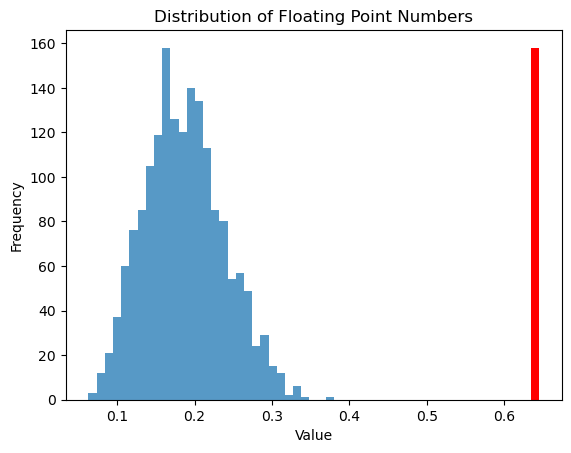

In [23]:
plot_distribution(traces, bins=30)

0.5832206 4.832463
[0.10745562 0.5241451  0.34397706 ... 0.2342865  0.4479091  0.16992515]


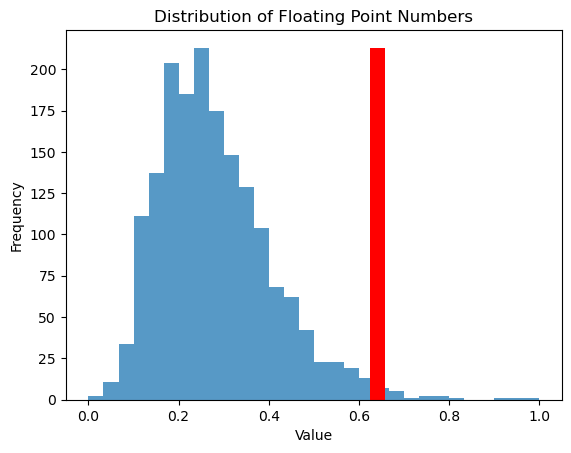

In [24]:
plot_distribution(normalize_values(test_snap_scores), bins=30)

In [56]:
snap_vs_trace = compute_similarity_metrics(normalize_values(test_snap_scores), normalize_values(1 / traces))

0.5832206 4.832463
[0.10745562 0.5241451  0.34397706 ... 0.2342865  0.4479091  0.16992515]
2.630688 15.8956375
[0.2054557  0.37997103 0.22989704 ... 0.2512917  0.26273993 0.13474996]


In [57]:
print(snap_vs_trace)

{'pearson_corr': 0.4803813230001833, 'spearman_corr': 0.5062263585240343, 'mse': 0.019464541, 'rmse': 0.13951539, 'cosine_sim': 0.89178383, 'kl_divergence': 67.551285, 'jaccard_sim': 0.0}


In [37]:
def fit_gmm_and_estimate_density(data, n_components=3):
    # Fit a Gaussian Mixture Model to the data
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data)

    # Estimate the density around each vector in the data
    log_prob_density = gmm.score_samples(data)

    return log_prob_density


prob_density = fit_gmm_and_estimate_density(e_peps, n_components=20)
print(len(prob_density), len(e_peps))
print(prob_density)
print(max(prob_density))

NameError: name 'e_peps' is not defined

In [27]:
def fit_vmf_and_estimate_density(data, n_clusters=3, max_iter=100, tol=1e-3):
    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Estimate the density around each vector in the data
    # density_estimates = vmf.predict_proba(data)
    # density_estimates = vmf.score(data)
    density_estimates = vmf.log_likelihood(data)

    return density_estimates


def fit_vmf_and_estimate_density_1(data, n_clusters=3, max_iter=100, tol=1e-3):
    m = data.shape[1]

    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Compute the log of the density estimate for each data point
    log_exp_terms = np.dot(data, vmf.cluster_centers_.T) * vmf.concentrations_
    log_const_terms = (np.log(vmf.concentrations_) * ((m - 1) / 2)) - (
        np.log(2 * np.pi) * (m / 2) + np.log(iv((m - 1) / 2, vmf.concentrations_))
    )
    log_density_estimate = logsumexp(log_const_terms + log_exp_terms, axis=1, b=vmf.weights_)

    # Normalize the log density estimates and convert back to the density estimate
    max_log_density_estimate = np.max(log_density_estimate)
    shifted_log_density_estimate = log_density_estimate - max_log_density_estimate
    sum_exp_shifted_log_density_estimate = np.sum(np.exp(shifted_log_density_estimate))
    normalized_log_density_estimate = shifted_log_density_estimate - np.log(sum_exp_shifted_log_density_estimate)
    density_estimate = np.exp(normalized_log_density_estimate)

    return log_density_estimate


def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [28]:
def plot_density_estimates(density_estimates, title="Density Estimates", xlabel="Vector Index", ylabel="Density"):
    n_vectors = len(density_estimates)
    vector_indices = np.arange(n_vectors)

    # Create a bar plot of the density estimates
    plt.bar(vector_indices, density_estimates)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(vector_indices)
    plt.show()

In [29]:
def plot_density_distribution(
    density_estimates, bins=None, title="Density Distribution", xlabel="Density", ylabel="Frequency"
):
    # Create a histogram of the density estimates
    plt.hist(density_estimates, bins=bins, alpha=0.75)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(min(density_estimates), max(density_estimates))
    plt.ylabel(ylabel)
    plt.show()

In [30]:
density_estimates_peps = fit_vmf_and_estimate_density_1(test_e_peps, n_clusters=20)
print(density_estimates_peps)
print(min(density_estimates_peps), max(density_estimates_peps))

[406.30665213 390.78785626 414.17724408 ... 408.3725993  381.22690715
 396.70655247]
358.78479301394646 458.3135246465157


In [31]:
density_estimates_peps = normalize_values(density_estimates_peps)

358.78479301394646 458.3135246465157
[0.47746875 0.32154598 0.55654734 ... 0.49822604 0.22548378 0.38101319]


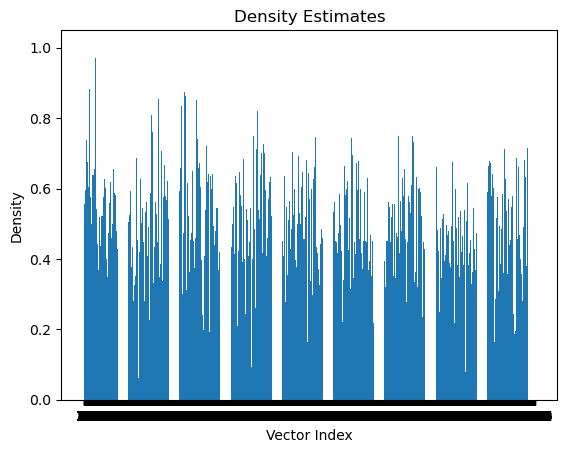

In [14]:
plot_density_estimates(density_estimates_peps)

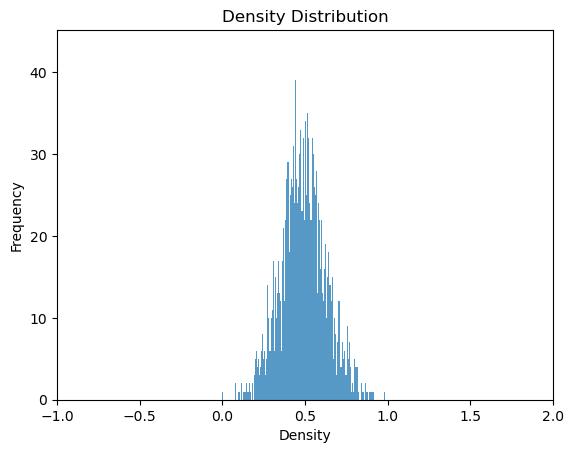

In [22]:
plot_density_distribution(normalized_values, bins=1000)

In [32]:
prob_density_specs = fit_vmf_and_estimate_density_1(test_e_specs[::k], n_clusters=20)

In [33]:
density = normalize_values(prob_density_specs)

358.1419048986833 481.8523463303675
[0.53734178 0.53837687 0.40516417 ... 0.70948473 0.32240378 0.84292089]


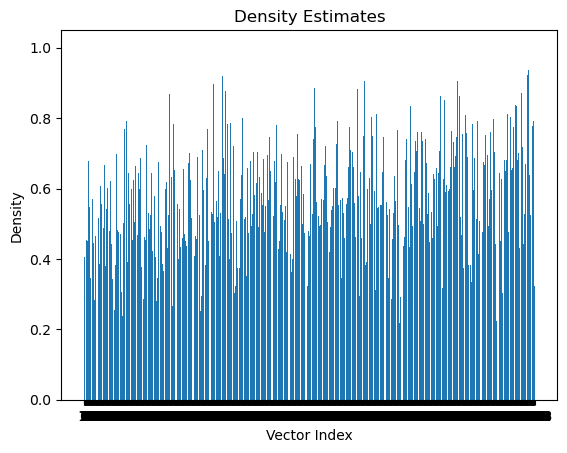

In [34]:
plot_density_estimates(density)

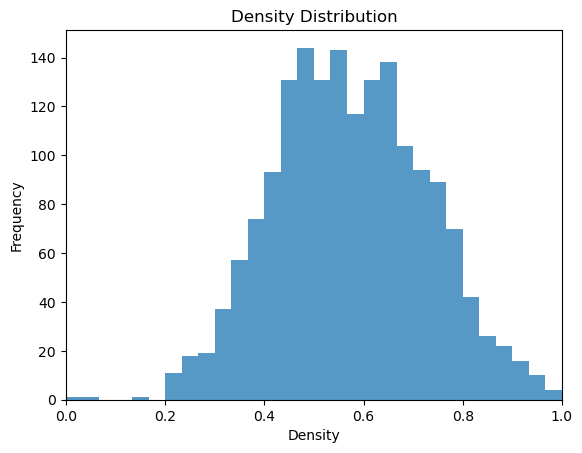

In [35]:
plot_density_distribution(density, bins=30)

In [36]:
snap_vs_density = compute_similarity_metrics(test_snap_scores, 1 - density)
print(snap_vs_density)

{'pearson_corr': 0.2837245723056015, 'spearman_corr': 0.29449624618686343, 'mse': 2.0925993509774936, 'rmse': 1.4465819544628273, 'cosine_sim': 0.9292721817528786, 'kl_divergence': inf, 'jaccard_sim': 0.0}


In [37]:
import numpy as np
from bisect import bisect_left, bisect_right
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity


def find_indices_within_tolerance(precursor_masses, target_mass, tol):
    lower_mass = target_mass - tol
    upper_mass = target_mass + tol

    lower_index = bisect_left(precursor_masses, lower_mass)
    upper_index = bisect_right(precursor_masses, upper_mass)

    return lower_index, upper_index


def spectral_similarity(spec1, spec2):
    mz1 = spec1[0].astype(int)
    mz2 = spec2[0].astype(int)

    intensity1 = spec1[1]
    intensity2 = spec2[1]

    dot_product = 0
    i, j = 0, 0
    while i < len(mz1) and j < len(mz2):
        if mz1[i] == mz2[j]:
            dot_product += intensity1[i] * intensity2[j]
            i += 1
            j += 1
        elif mz1[i] < mz2[j]:
            i += 1
        else:
            j += 1

    norm1 = np.linalg.norm(intensity1)
    norm2 = np.linalg.norm(intensity2)

    if norm1 != 0 and norm2 != 0:
        similarity = dot_product / (norm1 * norm2)
    else:
        similarity = 0

    return similarity


def msms_similarity(specs1, specs2, emb1, emb2, precursors1, precursors2, tol):
    # Initialize results matrix as a sparse matrix
    sim_matrix = lil_matrix((len(specs1), len(specs2)), dtype=np.float32)
    emb_sim_matrix = lil_matrix((len(emb1), len(emb2)), dtype=np.float32)

    # Iterate over all spectra in specs1
    for i in tqdm(range(len(specs1)), desc="Calculating spectral similarity"):
        # Find spectra in specs2 within tolerance
        start_index = bisect_left(precursors2, precursors1[i] - tol)
        end_index = bisect_right(precursors2, precursors1[i] + tol)

        for j in range(start_index, end_index):
            # Calculate spectral similarity
            sim_matrix[i, j] = spectral_similarity(specs1[i], specs2[j])

            # Calculate embedding similarity
            emb_sim_matrix[i, j] = cosine_similarity(emb1[i].reshape(1, -1), emb2[j].reshape(1, -1))[0][0]

    return sim_matrix.tocsr(), emb_sim_matrix.tocsr()


def normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    return (values - min_val) / (max_val - min_val)


def embedding_confidence(test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol, k):
    num_test = len(test_X)
    consistency = np.zeros(num_test)
    sim_X = np.zeros(num_test)
    sim_Y = np.zeros(num_test)

    # Get the spectral and embedding similarity matrices
    spec_sim_matrix, emb_sim_matrix = msms_similarity(test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol)

    for i in tqdm(range(num_test), desc="Get top k and calculate confidence"):
        # Get the spectral and embedding similarities for the i-th test example
        spec_similarities = spec_sim_matrix[i].toarray().flatten()
        emb_similarities = emb_sim_matrix[i].toarray().flatten()

        # Get the indices of the top-k most similar examples
        top_k_spec_indices = np.argpartition(spec_similarities, -k)[-k:]
        top_k_emb_indices = np.argpartition(emb_similarities, -k)[-k:]

        # Calculate the mean similarities in the input and embedding spaces
        mean_sim_X = np.mean(spec_similarities[top_k_spec_indices])
        mean_sim_Y = np.mean(emb_similarities[top_k_emb_indices])

        # Calculate the confidence score for the i-th test example
        sim_X[i] = mean_sim_X
        sim_Y[i] = mean_sim_Y
        consistency[i] = np.abs(mean_sim_X - mean_sim_Y)

    return consistency, sim_X, sim_Y

In [38]:
confidence = embedding_confidence(
    test_np_specs[::k], train_np_specs, test_e_specs[::k], q, test_spec_masses[::k], train_spec_masses, tol=10, k=5
)

Calculating spectral similarity:   0%|          | 0/1724 [00:00<?, ?it/s]

Get top k and calculate confidence:   0%|          | 0/1724 [00:00<?, ?it/s]

In [39]:
print(len(test_np_specs))

20688


In [40]:
data, sim_X, sim_Y = confidence
print(len(data))
print(min(data), max(data))
data_sorts = sorted(data, reverse=True)

1724
0.0 0.666401743888855


In [65]:
sim_X = sim_X[::k]
data = data[::k]
print(len(sim_X))

1724


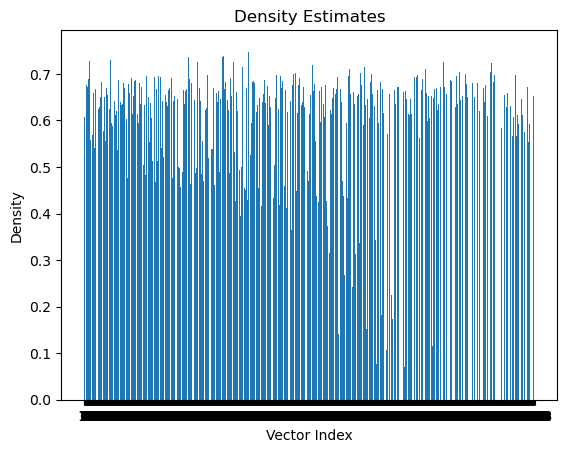

In [42]:
plot_density_estimates(sim_Y) # Not density estimates, but confidence estimates

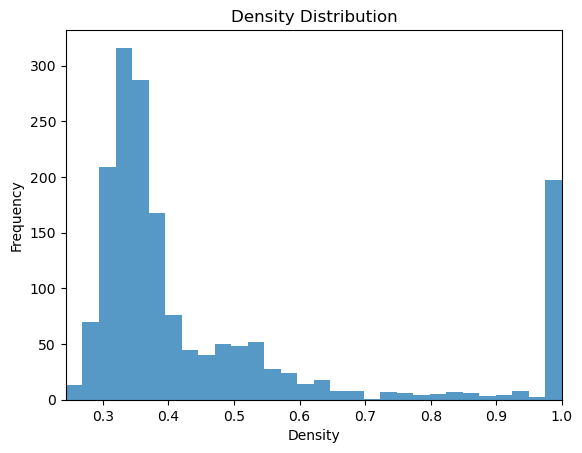

In [43]:
plot_density_distribution(1 - sim_Y, bins=30) # Not density distribution, but confidence distribution

In [44]:
test_snap_scores = np.array(test_snap_scores)
test_snap_scores = test_snap_scores[sim_X != 0]
sim_Y = sim_Y[sim_X != 0]
data  = data[sim_X != 0]
sim_X = sim_X[sim_X != 0]

In [45]:
print(compute_similarity_metrics(test_snap_scores, data))
print(compute_similarity_metrics(test_snap_scores, sim_X))
print(compute_similarity_metrics(test_snap_scores, sim_Y))

{'pearson_corr': -0.2775250144031419, 'spearman_corr': -0.2925791852538945, 'mse': 1.9440588681149746, 'rmse': 1.394295115144199, 'cosine_sim': 0.9268754443517702, 'kl_divergence': 1798.213179591371, 'jaccard_sim': 0.0}
{'pearson_corr': -0.02465317773566611, 'spearman_corr': -0.0029150180509469334, 'mse': 2.8641366541408804, 'rmse': 1.6923760380426331, 'cosine_sim': 0.8288717132618271, 'kl_divergence': 5176.10225223796, 'jaccard_sim': 0.0}
{'pearson_corr': -0.23417822703896823, 'spearman_corr': -0.2690511859642832, 'mse': 1.6153618957156761, 'rmse': 1.270968880703094, 'cosine_sim': 0.9298537072848836, 'kl_divergence': 1322.7857059392231, 'jaccard_sim': 0.0}


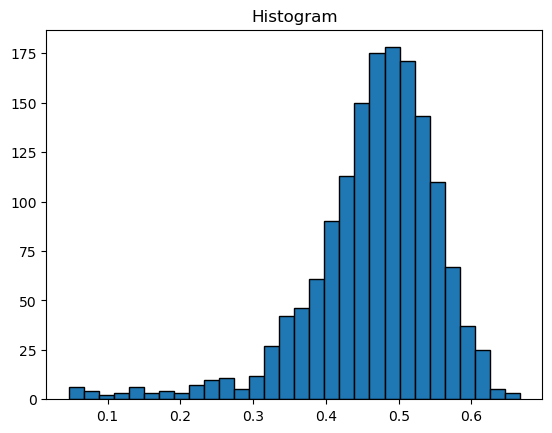

In [46]:
plt.hist(data, bins=30, edgecolor='black')
plt.title('Histogram')
plt.show()

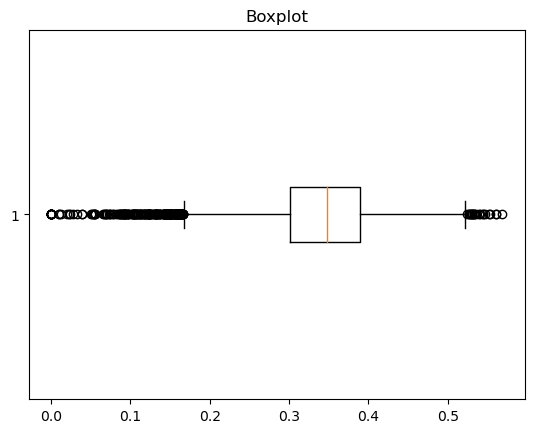

In [66]:
plt.boxplot(data, vert=False)
plt.title('Boxplot')
plt.show()

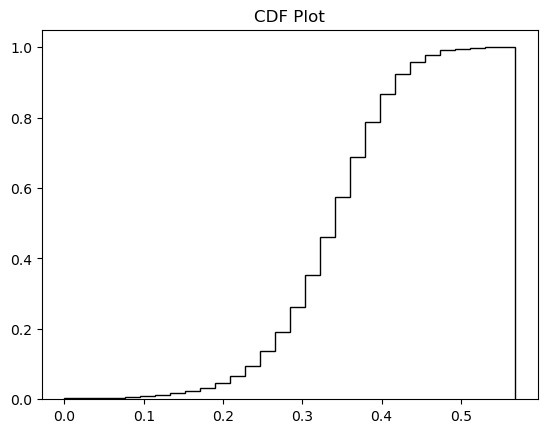

In [71]:
plt.hist(data, bins=30, cumulative=True, density=True, histtype='step', edgecolor='black')
plt.title('CDF Plot')
plt.show()


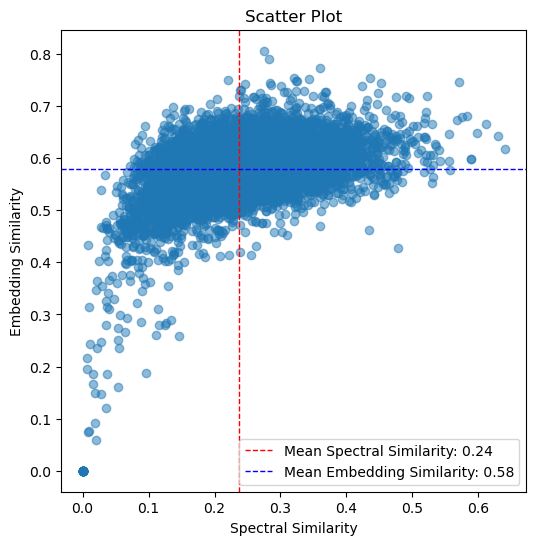

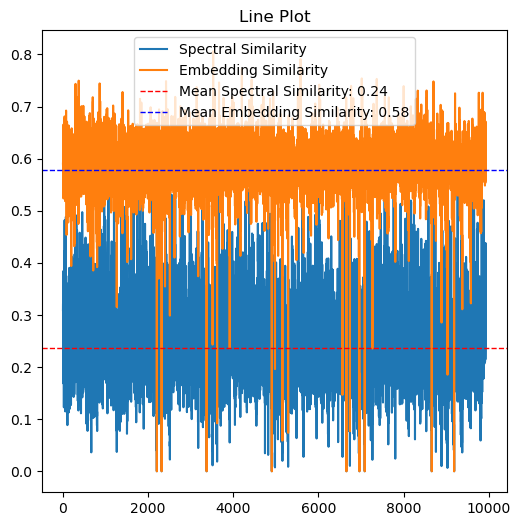

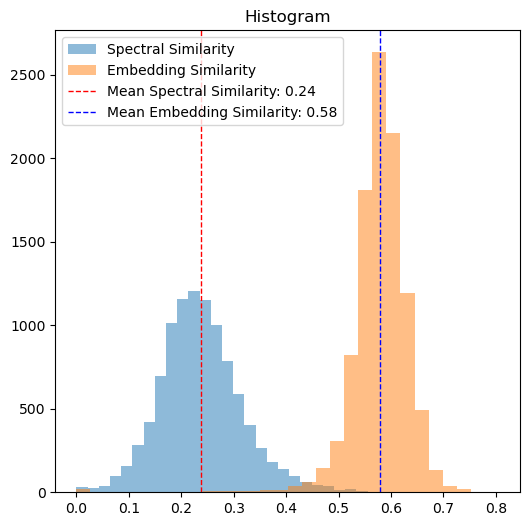

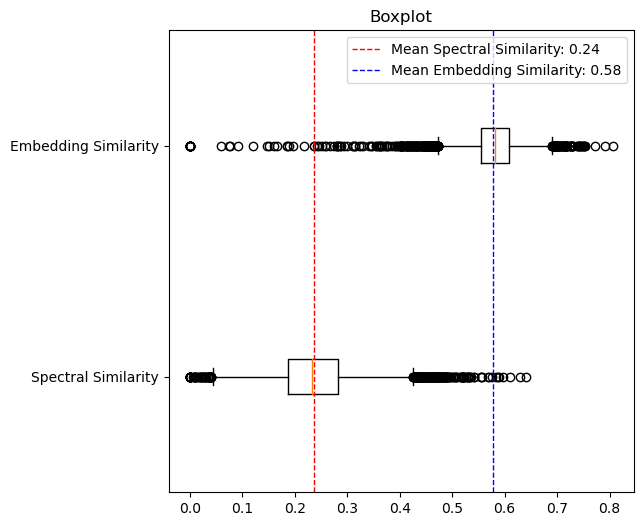

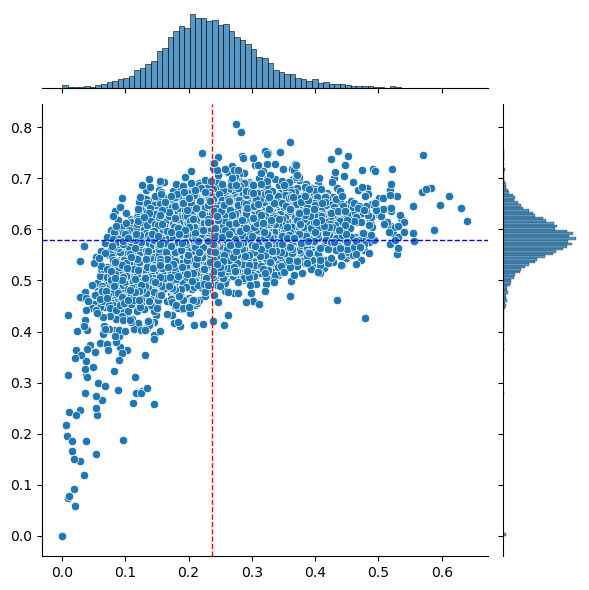

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming score1 and score2 are your vectors
traces = sim_X
score2 = sim_Y

# Calculate the means
mean1 = np.mean(traces)
mean2 = np.mean(score2)

# Scatter Plot
plt.figure(figsize=(6,6))
plt.scatter(traces, score2, alpha=0.5)
plt.axvline(mean1, color='r', linestyle='dashed', linewidth=1, label=f'Mean Spectral Similarity: {mean1:.2f}')
plt.axhline(mean2, color='b', linestyle='dashed', linewidth=1, label=f'Mean Embedding Similarity: {mean2:.2f}')
plt.title('Scatter Plot')
plt.xlabel('Spectral Similarity')
plt.ylabel('Embedding Similarity')
plt.legend()
plt.show()

# Line Plot
plt.figure(figsize=(6,6))
plt.plot(traces, label='Spectral Similarity')
plt.plot(score2, label='Embedding Similarity')
plt.axhline(mean1, color='r', linestyle='dashed', linewidth=1, label=f'Mean Spectral Similarity: {mean1:.2f}')
plt.axhline(mean2, color='b', linestyle='dashed', linewidth=1, label=f'Mean Embedding Similarity: {mean2:.2f}')
plt.title('Line Plot')
plt.legend()
plt.show()

# Histogram
plt.figure(figsize=(6,6))
plt.hist(traces, bins=30, alpha=0.5, label='Spectral Similarity')
plt.hist(score2, bins=30, alpha=0.5, label='Embedding Similarity')
plt.axvline(mean1, color='r', linestyle='dashed', linewidth=1, label=f'Mean Spectral Similarity: {mean1:.2f}')
plt.axvline(mean2, color='b', linestyle='dashed', linewidth=1, label=f'Mean Embedding Similarity: {mean2:.2f}')
plt.title('Histogram')
plt.legend()
plt.show()

# Boxplot
plt.figure(figsize=(6,6))
plt.boxplot([traces, score2], vert=False, labels=['Spectral Similarity', 'Embedding Similarity'])
plt.axvline(mean1, color='r', linestyle='dashed', linewidth=1, label=f'Mean Spectral Similarity: {mean1:.2f}')
plt.axvline(mean2, color='b', linestyle='dashed', linewidth=1, label=f'Mean Embedding Similarity: {mean2:.2f}')
plt.title('Boxplot')
plt.legend()
plt.show()

# Jointplot
g = sns.jointplot(x=traces, y=score2)
g.ax_joint.axvline(mean1, color='r', linestyle='dashed', linewidth=1)
g.ax_joint.axhline(mean2, color='b', linestyle='dashed', linewidth=1)
plt.show()

0.5832206 4.832463
[0.10745562 0.5241451  0.34397706 ... 0.2342865  0.4479091  0.16992515]
2.630688 15.8956375
[0.2054557  0.37997103 0.22989704 ... 0.2512917  0.26273993 0.13474996]
0.5832206 4.832463
[0.10745562 0.5241451  0.34397706 ... 0.2342865  0.4479091  0.16992515]
0.0 1.0
[0.46265822 0.46162313 0.59483583 ... 0.29051527 0.67759622 0.15707911]


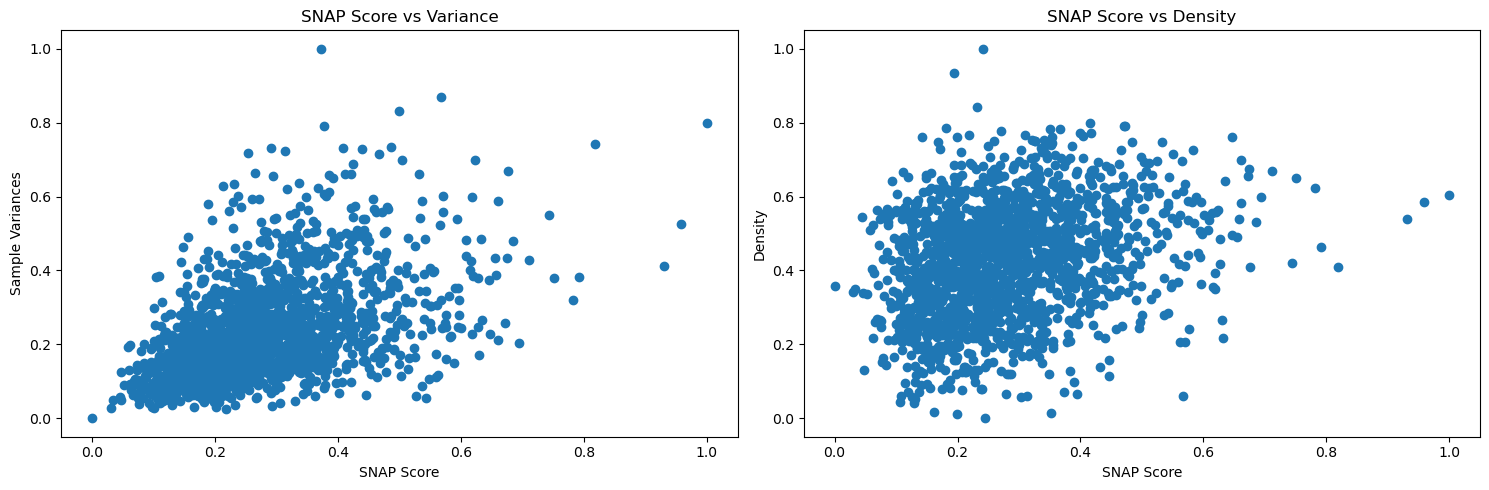

In [63]:
import matplotlib.pyplot as plt

# Assuming ref_scores, score1, score2, score3 are your score arrays
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(normalize_values(test_snap_scores), normalize_values(1 / traces))
plt.xlabel('SNAP Score')
plt.ylabel('Sample Variances')
plt.title('SNAP Score vs Variance')

plt.subplot(1, 2, 2)
plt.scatter(normalize_values(test_snap_scores), normalize_values(1 - density))
plt.xlabel('SNAP Score')
plt.ylabel('Density')
plt.title('SNAP Score vs Density')

plt.tight_layout()
plt.show()

In [ ]:
plt.subplot(1, 1, 1)
plt.scatter(test_snap_scores, consisitency)
plt.xlabel('SNAP Score')
plt.ylabel('Consistency')
plt.title('SNAP Score vs Consistency')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.preprocessing import StandardScaler

torch_specs_collated = spec_collate(torch_specs)
torch_peps_collated = pep_collate(torch_peps)
e_specs = runModel(torch_specs_collated, snap_model, "specs", rank).detach().numpy()
e_peps = runModel(torch_peps_collated, snap_model, "peps", rank).detach().numpy()

range_val = 40  # len(e_peps)
specs_per_pep = 15
spec_range = 0
for num_spec in num_specs[:range_val]:
    spec_range += num_spec

e_sp = np.concatenate((e_specs[:spec_range], e_peps[:range_val]))
e_charges = list(map(str, test_spec_charge_list[:spec_range]))
e_charges.extend([""] * range_val)
scaled_e_sp = StandardScaler().fit_transform(e_sp)

targets = []
for i, num_spec in enumerate(num_specs[:range_val]):
    targets.extend([0] * num_spec)
for i in range(range_val):
    targets.append(1)  # + range_val)

In [13]:
for i in range(10):
    print(test_pep_strings[i])

SKGPSAAGEQEPDKESGASVDEVAR
KYEVLALLYHEPPEDDKASQR
SSHEPTEDAAPIVSPLASPDPRTK
FDALKDDDSGDHDQNEENSTQK
DRIHCcVAYVLDINSIDNLYSK
VGGVGPADTHEPLRPEAEPGELER
GEEPPAAAPVSLPLPAHLHVFNPR
LHEEEPPQNMoKPQSGNDKPLSK
LHHPGVLCcQADGSTEEQAPGSSSR
LSSEHYSSQSHGNSMTELKPSSK


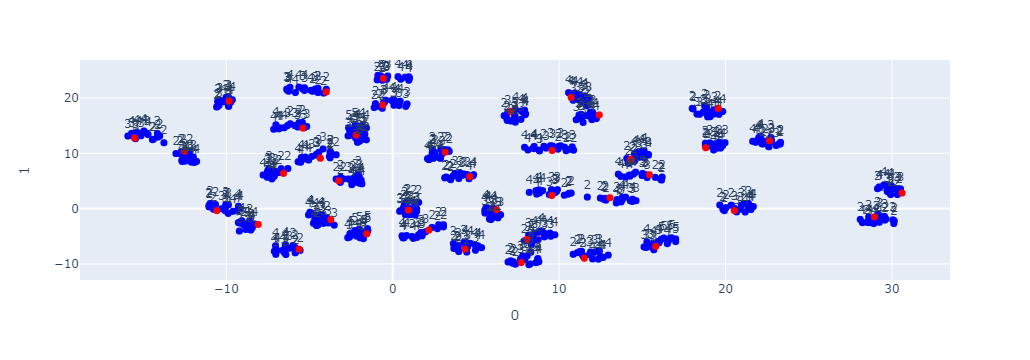

In [54]:
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

df = px.data.iris()

features = df.loc[:, :"petal_width"].to_numpy()
# print(features)

umap_2d = UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=1.0,
    metric="euclidean",
    init="random",
    random_state=0,
)
# umap_3d = UMAP(n_components=3, n_neighbors=5, min_dist=0.1, metric='euclidean', init='random', random_state=0)

proj_2d = umap_2d.fit_transform(scaled_e_sp)
# proj_3d = umap_3d.fit_transform(scaled_e_sp)

fig_2d = px.scatter(
    proj_2d,
    x=0,
    y=1,
    color=targets,
    color_continuous_scale=px.colors.sequential.Bluered,
    width=400,
    height=300,
    text=e_charges,
)
# fig_2d.add_scatter(x=proj_2d_peps[:,0], y=proj_2d_peps[:,1], mode='markers')

# fig_3d = px.scatter_3d(
#     proj_3d, x=0, y=1, z=2,
#     color=targets, labels={'color': 'species'}
# )

fig_2d.update_traces(marker_size=7, textposition="top center")
fig_2d.update_layout(coloraxis_showscale=False, font={"size": 12})

fig_2d.show()
# fig_3d.show()
# fig_2d.write_image("human_hcd_phospho-2d-20.png")
# fig_3d.write_image("human_hcd_phospho-3d-20.png")

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

umap_2d = UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=1.0,
    metric="euclidean",
    init="random",
    random_state=0,
)
proj_2d = umap_2d.fit_transform(scaled_e_sp)

x = proj_2d[:, 0]
y = proj_2d[:, 1]

plt.figure(figsize=(12, 10), dpi=600)
plt.grid(which="major", axis="both", zorder=-1.0)
plt.rcParams.update({"font.size": 18})
plt.scatter(x, y, c=targets, cmap="bwr", alpha=0.8, label="Luck")
# plt.title("2D Map of Peptides and Spectra being Projected ")
plt.xlabel("0")
plt.ylabel("1")
plt.savefig("temp.png", dpi=600)
plt.show()

In [5]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1


In [160]:
def ppm(val, ppm_val):
    return (ppm_val / 1000000) * val

In [161]:
search_spec_batch_size = 1
# search_spec_batch_size = 2048
precursor_tolerance = 5
keep_psms = 5

## Calculating XCorr

In [162]:
setup(rank, world_size)
if torch.cuda.is_available():
    torch.cuda.set_device(rank)
mgf_dir = config.get_config(key="mgf_dir", section="search")
prep_dir = config.get_config(key="prep_dir", section="search")
pep_dir = config.get_config(key="pep_dir", section="search")
out_pin_dir = config.get_config(key="out_pin_dir", section="search")

scratch_loc = "/scratch/mtari008/job_" + os.environ["SLURM_JOB_ID"] + "/"

mgf_dir = scratch_loc + mgf_dir
prep_dir = scratch_loc + prep_dir
pep_dir = scratch_loc + pep_dir
out_pin_dir = scratch_loc + out_pin_dir

if args.preprocess and args.preprocess == "True" and rank == 0:
    tqdm.write("Preprocessing mgf files...")
    preprocess.preprocess_mgfs(mgf_dir, prep_dir)

dist.barrier()

tqdm.write("Reading input files...")

spec_batch_size = config.get_config(key="spec_batch_size", section="search")
spec_dataset = specdataset.SpectralDataset(prep_dir)
spec_loader = torch.utils.data.DataLoader(
    dataset=spec_dataset, batch_size=spec_batch_size, collate_fn=dbsearch.spec_collate
)

pep_batch_size = config.get_config(key="pep_batch_size", section="search")
if rank == 0:
    pep_dataset = pepdataset.PeptideDataset(pep_dir)
    pep_loader = torch.utils.data.DataLoader(
        dataset=pep_dataset, batch_size=pep_batch_size, collate_fn=dbsearch.pep_collate
    )

dist.barrier()

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12350'
# dist.init_process_group(backend='nccl', world_size=1, rank=0)
# model_name = "512-embed-2-lstm-SnapLoss2D-80k-nist-massive-no-mc-semi-randbatch-62.pt" # 28.8k
model_name = "512-embed-2-lstm-SnapLoss2D-80k-nist-massive-no-mc-semi-r2r-18.pt"  # 28.975k
model_name = "512-embed-2-lstm-SnapLoss2D-80k-nist-massive-no-mc-semi-r2r2r-22.pt"
print("Using model: {}".format(model_name))
snap_model = model.Net(vocab_size=30, embedding_dim=512, hidden_lstm_dim=512, lstm_layers=2).to(rank)
snap_model = nn.parallel.DistributedDataParallel(snap_model, device_ids=[rank])
# snap_model.load_state_dict(torch.load('models/32-embed-2-lstm-SnapLoss2-noch-3k-1k-152.pt')['model_state_dict'])
# below one has 26975 identified peptides.
# snap_model.load_state_dict(torch.load('models/512-embed-2-lstm-SnapLoss-noch-80k-nist-massive-52.pt')['model_state_dict'])
# below one has 27.5k peps
# snap_model.load_state_dict(torch.load('models/hcd/512-embed-2-lstm-SnapLoss2D-inputCharge-80k-nist-massive-116.pt')['model_state_dict'])
snap_model.load_state_dict(torch.load("models/hcd/{}".format(model_name))["model_state_dict"])
snap_model = snap_model.module
snap_model.eval()
print(snap_model)

print("Processing spectra...")
e_specs = dbsearch.runModel(spec_loader, snap_model, "specs", rank)
print("Spectra done!")

dist.barrier()

if rank == 0:
    print("Processing peptides...")
    e_peps = dbsearch.runModel(pep_loader, snap_model, "peps", rank)
    print("Peptides done!")

if rank == 1:
    print("Processing decoys...")
    e_decs = dbsearch.runModel(dec_loader, snap_model, "peps", rank)
    print("Decoys done!")

dist.barrier()

search_spec_batch_size = config.get_config(key="search_spec_batch_size", section="search")
if rank == 0:
    datasets = {"spec_dataset": spec_dataset, "pep_dataset": pep_dataset}
    embeddings = {"e_specs": e_specs, "e_peps": e_peps}
if rank == 1:
    datasets = {"spec_dataset": spec_dataset, "dec_dataset": dec_dataset}
    embeddings = {"e_specs": e_specs, "e_decs": e_decs}
search_loader = torch.utils.data.DataLoader(dataset=e_specs, batch_size=search_spec_batch_size, shuffle=False)

inds, vals = dbsearch.parallel_search(search_loader, datasets, embeddings, rank)

pin_charge = config.get_config(section="search", key="charge")
charge_cols = [f"charge-{ch+1}" for ch in range(pin_charge)]
cols = (
    ["SpecId", "Label", "ScanNr", "SNAP", "ExpMass", "CalcMass", "deltCn", "deltLCn"]
    + charge_cols
    + ["dM", "absdM", "enzInt", "PepLen", "Peptide", "Proteins"]
)

dist.barrier()

if rank == 0:
    print("Generating percolator pin files...")
    global_out = postprocess.generate_percolator_input(inds, vals, pep_dataset, spec_dataset, "target")
    df = pd.DataFrame(global_out, columns=cols)
    df.sort_values(by="SNAP", inplace=True, ascending=False)
    df.to_csv(join(out_pin_dir, "target.pin"), sep="\t", index=False)

if rank == 1:
    global_out = postprocess.generate_percolator_input(inds, vals, dec_dataset, spec_dataset, "decoy")
    df = pd.DataFrame(global_out, columns=cols)
    df.sort_values(by="SNAP", inplace=True, ascending=False)
    df.to_csv(join(out_pin_dir, "decoy.pin"), sep="\t", index=False)
    print("Wrote percolator files: \n{}\n{}".format(join(out_pin_dir, "target.pin"), join(out_pin_dir, "decoy.pin")))


def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12345"
    torch.cuda.set_device(rank)
    dist.init_process_group(backend="nccl", world_size=world_size, rank=rank)

In [10]:
import numpy as np

a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[7, 8, 9], [10, 11, 12]])
c = np.concatenate((a, b))
print(a.shape)
print(b.shape)
print(c.shape)
print(c)

(2, 3)
(2, 3)
(4, 3)
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [27]:
list1 = [1, 2, 3, 4, 5]
list2 = ['a', 'b', 'c', 'd', 'e']
list3 = [50, 20, 40, 10, 30]

list4 = [list1, list3]

sorted_list1, sorted_list2, sorted_list3 = zip(*sorted(zip(list1, list2, list3), key=lambda x: x[2]))

print(sorted_list1)  # (4, 2, 5, 3, 1)
print(sorted_list2)  # ('d', 'b', 'e', 'c', 'a')
print(sorted_list3)  # (10, 20, 30, 40, 50)

print(np.concatenate(list4))

(4, 2, 5, 3, 1)
('d', 'b', 'e', 'c', 'a')
(10, 20, 30, 40, 50)
[ 1  2  3  4  5 50 20 40 10 30]
